# Portugese Meals Classification

## Data exploration

First of all I want to kniw are there any under/over represented classes and/or invalid images  
Additionally I'll need a DF to quickly get image_path-label pairs 

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from IPython.display import clear_output
import yaml

In [2]:
%cd ..

d:\GigaFolder\projects\Portuguese-Meals-Classification


In [3]:
config = yaml.safe_load(open('config.yaml', 'r'))

### Data work

In [4]:
classes = os.listdir(config['dataset']['data_dir'])
classes.sort()

labels = []
paths = []

for class_name in classes:
    class_path = os.path.join(config['dataset']['data_dir'], class_name)

    file_names = os.listdir(class_path)
    for file_name in file_names:
        file_path = os.path.join(class_path, file_name)
        
        try:    
            img = cv2.imread(file_path)
            shape = img.shape
            if len(shape) != 3:
                print('Image file ', file_path,
                      ' is not an rgb image and was not used in the dataframe')
            else:
                labels.append(class_name)
                paths.append(file_path)
        except:
            print('Image file ', file_path, ' is an invalid image and was not used')
# No exceptions = all images are valid

labels = pd.Series(labels, name = 'label')
paths = pd.Series(paths, name = 'path')
df = pd.concat([labels, paths], axis = 1)
df.to_csv(config['dataset']['csv_dir'] + 'full.csv', index = False)
df


,label,path
0,aletria,./data/raw/aletria\1.jpg
1,aletria,./data/raw/aletria\10.jpg
2,aletria,./data/raw/aletria\100.jpg
3,aletria,./data/raw/aletria\101.jpg
4,aletria,./data/raw/aletria\102.jpg
...,...,...
6721,waffles,./data/raw/waffles\971843.jpg
6722,waffles,./data/raw/waffles\97524.jpg
6723,waffles,./data/raw/waffles\98238.jpg
6724,waffles,./data/raw/waffles\995085.jpg


From this it's easy to see that `caldo_verde` and `croissant` are extremle under represented  
I quess I'll oversample theese classes (more augmented examples and duplication)

In [5]:
def print_class_count(df, name: str, ret = False):
    counts = {}
    print(f'{name} CLASS COUNTS:\n')
    for cls in classes:
        count = df["label"].where(df["label"] == cls).dropna().count()
        counts[cls] = count
        print(f'{cls:20s} : {count}')

    print(f'\nTotal samples: {len(counts)}')
    if ret:
        return counts

In [6]:
class_counts = print_class_count(df, 'Initial', True)

Initial CLASS COUNTS:

aletria              : 234
arroz_cabidela       : 97
bacalhau_bras        : 495
bacalhau_natas       : 97
batatas_fritas       : 541
bolo_chocolate       : 500
cachorro             : 490
caldo_verde          : 23
cozido_portuguesa    : 104
croissant            : 32
donuts               : 495
esparguete_bolonhesa : 491
feijoada             : 99
francesinha          : 500
gelado               : 525
hamburguer           : 494
jardineira           : 98
nata                 : 98
ovo                  : 96
pasteis_bacalhau     : 111
pizza                : 500
tripas_moda_porto    : 107
waffles              : 499

Total samples: 23


In [7]:
# Knowing this is good I quess? Though I didn't ever use this
height = []
width = []
for path in df['path']:
    im = cv2.imread(path)
    width.append(im.shape[0])
    height.append(im.shape[1])

print(f'Average aspect ration: {np.mean(width)/np.mean(height)}')
print(f'\nAverage width: {np.mean(width)}')
print(f'Min|Max width: {np.min(width)}, {np.max(width)}')

print(f'\nAverage height: {np.mean(height)}')
print(f'Min|Max height: {np.min(height)}, {np.max(height)}')


Average aspect ration: 0.8651361721825422

Average width: 571.5801367826346
Min|Max width: 140, 4296

Average height: 660.6822777282189
Min|Max height: 176, 4928


## Training/Testing/Validation splitting

I'll take `10%` of ORIGINAL images for validation

In [8]:
dummy_df = shuffle(df, random_state=config['random_seed'])
val_df = dummy_df[:int(len(df) * config['dataset']['validation_ratio'])]
assert config['class_count'] == val_df.label.nunique()

train_test_df = dummy_df[int(len(df) * config['dataset']['validation_ratio']):]
del dummy_df

val_df.to_csv(config['dataset']['csv_dir'] + 'val.csv', index=False)
train_test_df.to_csv(config['dataset']['csv_dir'] + 'test_train.csv', index = False)


In [9]:
print_class_count(val_df, 'Validation set')

Validation set CLASS COUNTS:

aletria              : 26
arroz_cabidela       : 7
bacalhau_bras        : 42
bacalhau_natas       : 10
batatas_fritas       : 39
bolo_chocolate       : 44
cachorro             : 56
caldo_verde          : 3
cozido_portuguesa    : 13
croissant            : 5
donuts               : 52
esparguete_bolonhesa : 56
feijoada             : 11
francesinha          : 45
gelado               : 52
hamburguer           : 50
jardineira           : 12
nata                 : 12
ovo                  : 8
pasteis_bacalhau     : 11
pizza                : 42
tripas_moda_porto    : 16
waffles              : 60

Total samples: 23


In [10]:
print_class_count(train_test_df, 'Test-train set (before processing)')

Test-train set (before processing) CLASS COUNTS:

aletria              : 208
arroz_cabidela       : 90
bacalhau_bras        : 453
bacalhau_natas       : 87
batatas_fritas       : 502
bolo_chocolate       : 456
cachorro             : 434
caldo_verde          : 20
cozido_portuguesa    : 91
croissant            : 27
donuts               : 443
esparguete_bolonhesa : 435
feijoada             : 88
francesinha          : 455
gelado               : 473
hamburguer           : 444
jardineira           : 86
nata                 : 86
ovo                  : 88
pasteis_bacalhau     : 100
pizza                : 458
tripas_moda_porto    : 91
waffles              : 439

Total samples: 23


And now I'll do some dataset balancing and image augmentation

## Data preprocessing


### Augmentation & transformation

In [11]:
import albumentations as A
from sklearn.preprocessing import LabelBinarizer

In [12]:
a = train_test_df.copy()
assert len(train_test_df) == len(a)

In [13]:
# first of all - duplicate (twice) underrepresented classes (~30 ex.)
for idx in range(len(a)):
    cls, path = a.iloc[idx]
    if class_counts[cls] < 50:
        a = a.append({'label': cls, 'path': path}, ignore_index= True)
        a = a.append({'label': cls, 'path': path}, ignore_index= True)

clear_output()
len(a)
# now there're ~60-90 examples of examples of under represented classes

6148

In [14]:
# now I'll remove around 250 examples of overrepresented classes
b = a.copy() 
for idx in range(len(a)):
    cls, path = a.iloc[idx]
    if b["label"].where(b["label"] == cls).dropna().count() > 250:
        b = b.drop(b[b.path == path].index)

clear_output()
len(b)
# now there 250 examples of over-represented classes
# (60-90)underrepresented, 200aletria, 250overrepresented, 100normaly distibuted

3906

In [15]:
# And so training-test spit is:
print_class_count(b, 'Train-test set (step 1 of processing)')

Train-test set (step 1 of processing) CLASS COUNTS:

aletria              : 208
arroz_cabidela       : 90
bacalhau_bras        : 250
bacalhau_natas       : 87
batatas_fritas       : 250
bolo_chocolate       : 250
cachorro             : 250
caldo_verde          : 60
cozido_portuguesa    : 91
croissant            : 81
donuts               : 250
esparguete_bolonhesa : 250
feijoada             : 88
francesinha          : 250
gelado               : 250
hamburguer           : 250
jardineira           : 86
nata                 : 86
ovo                  : 88
pasteis_bacalhau     : 100
pizza                : 250
tripas_moda_porto    : 91
waffles              : 250

Total samples: 23


In [16]:
train_test_df = shuffle(b)
del a
del b
len(train_test_df)

3906

In [17]:
transformation = A.Compose(
    [
        A.Rotate(limit=15, p=1),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.GaussianBlur(blur_limit=(3, 9), p=0.6),
        A.RandomBrightnessContrast(p=0.4),
    ]
)


def resize(image, image_size=config['img_shape'][0]):
    # I'll go for a square image
    return cv2.resize(image, (image_size, image_size), interpolation=cv2.INTER_AREA)


def augment(image):
    return transformation(image=image)['image']


def normalize(image):
    image = image / 255
    return image


def preprocess(image):
    image = augment(image)
    image = resize(image)
    image = normalize(image)
    return image


In [18]:
labels = []
images = []

for idx in range(len(train_test_df)):
    cls, path = train_test_df.iloc[idx]
    image = cv2.imread(path)
    # special case (~200 ex.) over representer case (~450 ex.)
    if cls == 'aletria' or class_counts[cls] >= 430:
        im1 = augment(image)
        im1 = resize(im1)
        im1 = normalize(im1)

        labels.append(cls)

        images.append(im1)

    else:  # under represented cae (~30 ex.) and normal case (~100 ex.)
        im1 = augment(image)
        im1 = resize(im1)
        im1 = normalize(im1)

        im2 = augment(image)
        im2 = resize(im2)
        im2 = normalize(im2)

        image = resize(image)
        image = normalize(image)

        labels.append(cls)
        labels.append(cls)
        labels.append(cls)

        images.append(im1)
        images.append(im2)
        images.append(image)
        
len(labels)


5802

In [19]:
arr = np.array(labels)
u, c = np.unique(arr, return_counts=True)
print(np.asarray((u, c)).T)


[['aletria' '208']
 ['arroz_cabidela' '270']
 ['bacalhau_bras' '250']
 ['bacalhau_natas' '261']
 ['batatas_fritas' '250']
 ['bolo_chocolate' '250']
 ['cachorro' '250']
 ['caldo_verde' '180']
 ['cozido_portuguesa' '273']
 ['croissant' '243']
 ['donuts' '250']
 ['esparguete_bolonhesa' '250']
 ['feijoada' '264']
 ['francesinha' '250']
 ['gelado' '250']
 ['hamburguer' '250']
 ['jardineira' '258']
 ['nata' '258']
 ['ovo' '264']
 ['pasteis_bacalhau' '300']
 ['pizza' '250']
 ['tripas_moda_porto' '273']
 ['waffles' '250']]


In [20]:
encoder = LabelBinarizer()
labels = np.asarray(labels)
labels = encoder.fit_transform(labels)

images = np.asarray(images)


### Compression/uncompression

In [4]:
def compress_splits(X, Y, dir):
    np.savez_compressed(dir + 'Xvalues.npz', X)
    np.savez_compressed(dir + 'Yvalues.npz', Y)


def uncompress_splits(dir: str):
    X = np.load(dir + 'Xvalues.npz')['arr_0']
    Y = np.load(dir + 'Yvalues.npz')['arr_0']

    return X, Y

In [5]:
# compress_splits(images, labels, config['dataset']['augmented_dir'])
images, labels = uncompress_splits(config['dataset']['augmented_dir'])

In [6]:
images, labels = shuffle(images, labels, random_state=config['random_seed'])

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    images, labels, test_size=config['dataset']['test_ratio'], random_state=config['random_seed'])


## Model Tensorflow

In [9]:
import tensorflow as tf
from keras import regularizers
from keras.layers import BatchNormalization
from keras.layers import Dense
from keras.layers import Dropout
from tensorflow.keras.optimizers import Adamax
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt


In [26]:
base_model = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False, weights="imagenet", input_shape=config['img_shape'], pooling='max')

base_model.trainable = True

x = base_model.output
x = BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001)(x)
x = Dense(256, kernel_regularizer=regularizers.l2(l=0.016), activity_regularizer=regularizers.l1(0.006),
          bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
x = Dropout(rate=.4, seed=123)(x)
output = Dense(config['class_count'], activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(Adamax(learning_rate=config['train']['lr']),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=config['train']['label_smoothing']), metrics=config['train']['metrics'])


43941136/43941136 [==============================] - 48s 1us/step


In [ ]:
with wandb.init(project=config['wandb']['project'],
                name=config['wandb']['name'],
                job_type='Training',
                config=config):
    callbacks = [EarlyStopping(**config['callbacks']['EarlyStopping']),
                    ReduceLROnPlateau(**config['callbacks']['ReduceLROnPlateau']),
                    WandbCallback(**config['callbacks']['WandbCallback'])]

    history = model.fit(
        x_train, y_train,
        epochs=config['train']['epochs'],
        batch_size=config['train']['batch_size'],
        validation_data=(x_test, y_test),
        callbacks=callbacks
    )


In [ ]:
def plot_history(history):
    tacc=history.history['accuracy']
    tloss=history.history['loss']
    vacc=history.history['val_accuracy']
    vloss = history.history['val_loss']

    epochs=[]

    for i in range(len(tacc)):
        epochs.append(i+1)   

    index_loss=np.argmin(vloss)
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]

    plt.style.use('fivethirtyeight')

    sc_label='best epoch= '+ str(index_loss+1)
    vc_label='best epoch= '+ str(index_acc + 1)
    _,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))

    axes[0].plot(epochs,tloss, 'r', label='Training loss')
    axes[0].plot(epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()

    axes[1].plot (epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()

    plt.tight_layout    
    plt.show()

In [ ]:
plot_history(history)

In [ ]:
model.save(config['baseline_path'])

## Testing/Validation

In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [47]:
model = tf.keras.models.load_model(config['baseline_path'])

In [48]:
def validate_on_dataframe(model, df, name):
    preds = []
    true = []
    for idx in range(len(df)):
        cls, path = df.iloc[idx]
        image = cv2.imread(path)

        im1 = preprocess(image)
        im2 = preprocess(image)
        im3 = preprocess(image)
        im4 = preprocess(image)
        im5 = preprocess(image)

        image_batch = np.array([im1, im2, im3, im4, im5])
        res = model.predict(image_batch, verbose=0)

        pred = (res[0] + res[1] + res[2] + res[3] + res[4])
        preds.append(pred)
        true.append(cls)

    true_oh = encoder.fit_transform(np.array(df.label))
    res = []
    for idx in range(len(preds)):
        res.append(np.argmax(true_oh[idx]) == np.argmax(preds[idx]))
        # print(f'True idx = {np.argmax(true[idx])}')
        # print(f'Predicted idx = {np.argmax(preds[idx])}')
    print(f'Accuracy: {np.sum(res) / np.sum(true_oh)*100:.04}%')

    preds = encoder.inverse_transform(np.array(preds))
    cm = confusion_matrix(np.array(df.label), preds)
    plt.figure(figsize=(20, 16))
    cm = sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
    plt.xticks(np.arange(config['class_count'])+.5, classes, rotation=90)
    plt.yticks(np.arange(config['class_count'])+.5, classes, rotation=0)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()
    # create classification report
    clr = classification_report(np.array(df.label),
                                preds, target_names=classes, digits=4)
    print(f"Classification Report for {name}:\n----------------------\n", clr)

    wandb.log({f'confusion_matrix_{name}': wandb.Image(cm)})
    wandb.log({f'{name}_accuracy:': np.sum(res) / np.sum(true_oh)*100})


Accuracy: 96.43%


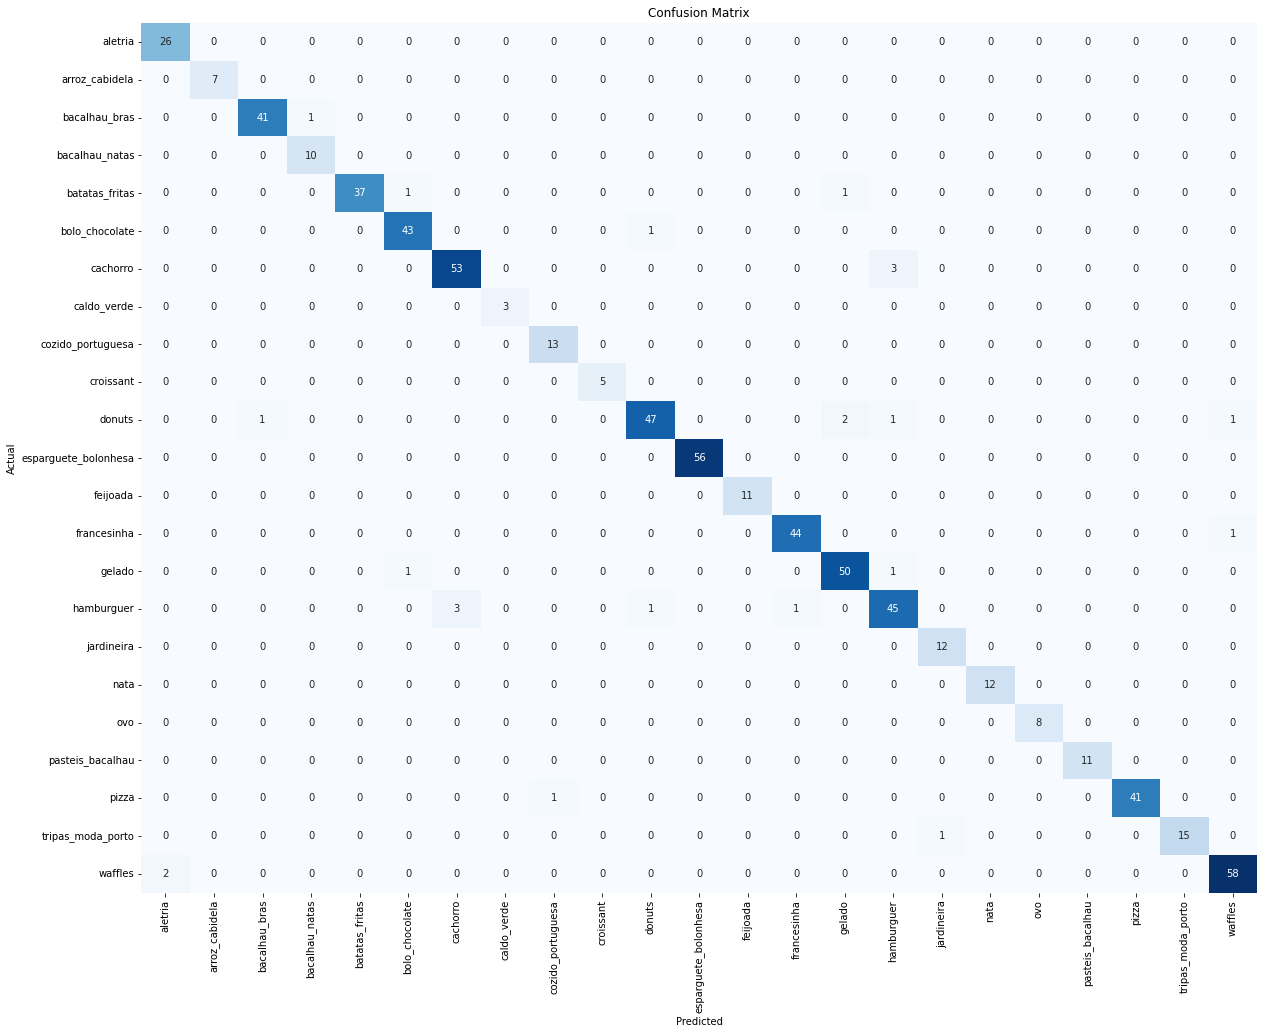

Classification Report:
----------------------
                       precision    recall  f1-score   support

             aletria     0.9286    1.0000    0.9630        26
      arroz_cabidela     1.0000    1.0000    1.0000         7
       bacalhau_bras     0.9762    0.9762    0.9762        42
      bacalhau_natas     0.9091    1.0000    0.9524        10
      batatas_fritas     1.0000    0.9487    0.9737        39
      bolo_chocolate     0.9556    0.9773    0.9663        44
            cachorro     0.9464    0.9464    0.9464        56
         caldo_verde     1.0000    1.0000    1.0000         3
   cozido_portuguesa     0.9286    1.0000    0.9630        13
           croissant     1.0000    1.0000    1.0000         5
              donuts     0.9592    0.9038    0.9307        52
esparguete_bolonhesa     1.0000    1.0000    1.0000        56
            feijoada     1.0000    1.0000    1.0000        11
         francesinha     0.9778    0.9778    0.9778        45
              gelado  

baseline_accuracy:,▁
baseline_accuracy:,96.42857


In [47]:
with wandb.init(project=config['wandb']['project'],
                name=config['wandb']['name'],
                job_type='Validation',
                config=config):
    validate_on_dataframe(model, val_df, 'baseline')


## Optimization

In [13]:
import tempfile
import tensorflow as tf
import tensorflow_model_optimization as tfmot
import numpy as np
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from wandb.keras import WandbCallback
import pathlib

So pruning doesn't work because of unsupported layers...  
Than I'll just quantize it

In [22]:
def quantize(model, save_path):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    tflite_model_file = pathlib.Path(save_path)
    tflite_model_file.write_bytes(tflite_model)

In [45]:
# def prune(config, model):
#     prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

#     end_step = np.ceil(
#         config['amount'] / config['optimize']['batch_size']).astype(np.int32) * config['optimize']['epochs']
#     pruning_params = {
#         'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
#                                                                  final_sparsity=0.80,
#                                                                  begin_step=0,
#                                                                  end_step=end_step)
#     }

#     model_for_pruning = prune_low_magnitude(model, **pruning_params)

#     # `prune_low_magnitude` requires a recompile.
#     model_for_pruning.compile(Adamax(learning_rate=config['optimize']['lr']),
#                               loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=config['optimize']['label_smoothing']), metrics=config['optimize']['metrics'])

#     logdir = tempfile.mkdtemp()
#     callbacks = [tfmot.sparsity.keras.UpdatePruningStep(),
#                  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
#                  EarlyStopping(**config['callbacks']['EarlyStopping']),
#                  ReduceLROnPlateau(**config['callbacks']['ReduceLROnPlateau']),
#                  WandbCallback(**config['callbacks']['WandbCallback'])]

#     history = model_for_pruning.fit(
#         x_train, y_train,
#         epochs=config['optimize']['epochs'],
#         batch_size=config['optimize']['batch_size'],
#         validation_data=(x_test, y_test),
#         callbacks=callbacks)

#     return history, model_for_pruning


# def strip_pruning(model, save_path):
#     model_for_export = tfmot.sparsity.keras.strip_pruning(model)
#     model_for_export.save(save_path)

#     return model_for_export


# def compare_baseline_to_pruned(baseline, pruned):
#     _, baseline_accuracy = baseline.evaluate(
#         x_test, y_test, verbose=0)

#     _, pruned_accuracy = pruned.evaluate(
#         x_test, y_test, verbose=0)

#     wandb.log({"baseline_accuracy": baseline_accuracy * 100})
#     wandb.log({"pruned_accuracy": pruned_accuracy * 100})

#     print('Baseline test accuracy:', baseline_accuracy * 100)
#     print('Pruned test accuracy:', pruned_accuracy * 100)


In [ ]:
# with wandb.init(project=config['wandb']['project'],
#                 name=config['wandb']['name'],
#                 job_type='Optimization',
#                 config=config):
#     prune_history, pruned_model = prune(model)
#     pruned_model = strip_pruning(pruned_model, config['pruned_path'])
#     compare_baseline_to_pruned(model, pruned_model)


In [23]:
model = tf.keras.models.load_model(config['baseline_path'])
quantize(model, config['tflite_path'])

INFO:tensorflow:Assets written to: C:\Users\3mpti\AppData\Local\Temp\tmpd_9x67ix\assets


INFO:tensorflow:Assets written to: C:\Users\3mpti\AppData\Local\Temp\tmpd_9x67ix\assets


## TFLite 

In [10]:
import tensorflow as tf

In [24]:
interpreter = tf.lite.Interpreter(model_path=config['tflite_path'])
interpreter.allocate_tensors() 

In [31]:
idx = 0
input_data = x_test[idx]
input_data = np.expand_dims(input_data, axis=0)
input_data = tf.convert_to_tensor(input_data, dtype=tf.float32)

In [42]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [33]:
interpreter.set_tensor(input['index'], input_data)
interpreter.invoke()
output = interpreter.get_tensor(output['index'])


In [34]:
np.argmax(output) == np.argmax(y_test[idx])

True

### TFlite validation

In [ ]:
TEST_CASES = len(x_test)
exps = []
ress = []
for i in range(TEST_CASES):
  expected = model.predict(x_test[i:i+1])
  interpreter.set_tensor(
      input_details['index'], x_test[i:i+1, :, :].astype(np.float32))
  interpreter.invoke()
  result = interpreter.get_tensor(output_details['index'])

  exps.append(expected)
  ress.append(result)

In [49]:
rights = 0
for idx in range(len(x_test)):
    if np.argmax(exps[idx]) == np.argmax(ress[idx]):
        rights+=1

print(f'TFlite model accuracy comared to TF model: {len(x_test) / rights}')

TFlite model accuracy comared to TF model: 1.0
